In [13]:
import os, time
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss 
from pdfCropMargins import crop
pd.options.mode.chained_assignment = None  # default='warn'
import pickle 

In [15]:
base_dir_mit = '/data/ddmg/scate/multiple_shortcut/dr'
base_dir_gl = '/nfs/turbo/coe-soto/mmakar/multiple_shortcut/dr'
if os.path.exists(base_dir_mit):
    base_dir = base_dir_mit
elif os.path.exists(base_dir_gl):
    base_dir = base_dir_gl 
    
pixel = 299 
batch_size = 64 
py1y0 = 0.9
seed_list = [i for i in range(10)]

In [16]:

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def single_class_auc(y_cat_true, y_cat_pred, single_class):
    y_true = (y_cat_true == single_class) * 1
    y_pred = y_cat_pred[[f'predictions{single_class}']]
    return roc_auc_score(y_true, y_pred)

def get_micro_auc(df):
    df = pd.concat([df, pd.get_dummies(df.y0, prefix='y0')], axis=1)
    final_df = []
    for y_val in df.y0.unique().tolist():
        curr_df = df[[f'y0_{y_val}',  f'predictions{int(y_val)}']]
        curr_df.rename(columns={f'y0_{y_val}': 'y_true', 
            f'predictions{int(y_val)}': 'y_pred'}, inplace=True)
        final_df.append(curr_df)
    
    final_df = pd.concat(final_df, ignore_index=True, axis=0)
    return roc_auc_score(final_df.y_true, final_df.y_pred)


In [17]:
def get_per_dist_metrics(df):
    all_results = []
    for dist in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
#     for dist in [0.1, 0.5, 0.9]:
        curr_df = df[(df.dist==dist)]
        curr_eval = {'dist': dist}
        curr_eval['macro_auc'] = roc_auc_score(curr_df.y0, curr_df[
            [f'predictions{i}' for i in range(5)]], average='macro', multi_class='ovr')
#         curr_eval['micro_auc'] = roc_auc_score(curr_df.y0, curr_df[
#             [f'predictions{i}' for i in range(5)]], average='micro', multi_class='ovr')
        curr_eval['micro_auc'] = get_micro_auc(curr_df)
        curr_eval['log_loss'] = log_loss(curr_df.y0, curr_df[
            [f'predictions{i}' for i in range(5)]])
        
        for single_class in range(5):
            curr_eval[f'auc{single_class}'] = single_class_auc(curr_df.y0, curr_df[
                [f'predictions{i}' for i in range(5)]], single_class)
        curr_eval['worst_auc'] = np.min([curr_eval[f'auc{i}'] for i in range(5)])
        all_results.append(curr_eval)
    return pd.DataFrame(all_results)
    

def get_all_dist_metrics(random_seeds, model_name, xv_mode, py1y0=0.9):
    all_eval = []
    for random_seed in random_seeds: 
#         print((f'{base_dir}/final_models/opt_pred_rs{random_seed}_{model_name}_{xv_mode}'
#              f'_pix{pixel}_bs{batch_size}_py1y0{py1y0}.csv'))
        modification_time = os.path.getmtime((f'{base_dir}/final_models/opt_pred_rs{random_seed}_{model_name}_{xv_mode}'
             f'_pix{pixel}_bs{batch_size}_py1y0{py1y0}.csv'))
        local_time = time.ctime(modification_time)
        print(local_time)
        curr_pred = pd.read_csv(
            (f'{base_dir}/final_models/opt_pred_rs{random_seed}_{model_name}_{xv_mode}'
             f'_pix{pixel}_bs{batch_size}_py1y0{py1y0}.csv')) 
        all_eval.append(get_per_dist_metrics(curr_pred))
        
    all_eval = pd.concat(all_eval, ignore_index=True)
    if len(random_seeds) > 1:
        all_eval = all_eval.groupby('dist').agg(
            [np.mean, np.std, np.median, percentile(25), percentile(75)]
        ).reset_index()
        all_eval.columns = ['_'.join(col).strip() for col in all_eval.columns.values]
        all_eval.rename(columns={'dist_': 'dist'}, inplace=True)
        for col in all_eval.columns:
            if 'std' in col:
                all_eval[col] = all_eval[col]/np.sqrt(len(random_seeds)*1.0)
                
    return all_eval


def get_all_dist_metrics_all_models(random_seed, model_name, xv_mode, py1y0=0.9):
    all_eval = []
    curr_pred = pd.read_csv(
        (f'{base_dir}/final_models/all_pred_{model_name}_{xv_mode}'
         f'_pix{pixel}_bs{batch_size}_py1y0{py1y0}_epochs2.csv')) 
    for model in curr_pred.model.unique().tolist():
        model_pred = curr_pred[(curr_pred.model == model)]
        model_eval = get_per_dist_metrics(model_pred)
        model_eval['model'] = f'{model_name}-{model[:5]}'
        all_eval.append(model_eval)
        
    all_eval = pd.concat(all_eval, ignore_index=True)
    return all_eval
        
    
    

In [18]:
model_name = 'unweighted_baseline'
xv_mode = 'classic'
uw_eval = get_all_dist_metrics(seed_list, model_name, xv_mode)
uw_eval['model'] = 'L2'

Tue May 17 07:59:19 2022
Tue May 17 08:02:29 2022
Tue May 17 08:05:39 2022
Tue May 17 08:08:49 2022
Tue May 17 08:11:59 2022
Tue May 17 08:15:08 2022
Tue May 17 08:18:17 2022
Tue May 17 08:21:26 2022
Tue May 17 08:24:36 2022
Tue May 17 08:27:45 2022


In [19]:
model_name = 'weighted_baseline'
xv_mode = 'classic'
w_eval = get_all_dist_metrics(seed_list, model_name, xv_mode)
w_eval['model'] = 'W-L2'

Wed May 18 15:39:03 2022
Wed May 18 15:42:20 2022
Wed May 18 15:45:32 2022
Wed May 18 15:48:41 2022
Wed May 18 15:51:56 2022
Wed May 18 15:55:18 2022
Wed May 18 15:58:25 2022
Wed May 18 16:01:37 2022
Wed May 18 16:04:44 2022
Wed May 18 16:07:50 2022


In [20]:
model_name = 'weighted_hsic'
xv_mode = 'two_step'
# wh_eval = get_all_dist_metrics_all_models(random_seed, model_name, xv_mode)
# wh_eval_lst_or = [wh_eval[(wh_eval.model== model)] for model in wh_eval.model.unique().tolist()]

# wh_eval_lst = [df for df in wh_eval_lst_or if df.micro_auc[(df.dist==0.1)].values[0] > 0.37 ]
# wh_eval_lst = [df for df in wh_eval_lst if df.micro_auc[(df.dist==0.9)].values[0] > 0.55 ]

wh_eval = get_all_dist_metrics(seed_list, model_name, xv_mode)
wh_eval['model'] = 'Ours'
# wh_eval_lst = [wh_eval]


Wed May 18 15:30:55 2022
Wed May 18 15:33:57 2022
Wed May 18 15:37:02 2022
Wed May 18 15:40:06 2022
Wed May 18 15:43:17 2022
Wed May 18 15:46:22 2022
Wed May 18 15:49:27 2022
Wed May 18 15:52:31 2022
Wed May 18 15:55:36 2022
Wed May 18 15:58:42 2022


In [21]:
eval_perf = {
    'uw_l2': uw_eval,  
    'w_l2': w_eval, 
    'ours': wh_eval
}

pickle.dump(eval_perf, open(f'{base_dir}/final_models/final_plot_results.pkl', 'wb'))


In [9]:
# rng = np.random.RandomState(0)
# r = lambda: rng.choice(range(255))
# wh_eval_lst = [wh_eval_lst_or[8], wh_eval_lst_or[4]]
# 2, 4, 6, 7 --> s 10 
# 3, 9 --> good

In [8]:
def generate_plot(df_lst, lab_lst, metric, stat):  
    x_loc = [i for i in range(len(df_lst[0].dist.unique()))]
    for df_i, df in enumerate(df_lst):
        
        if f'{metric}_{stat}' in df.columns:
            plt.errorbar(x_loc, df[f'{metric}_{stat}'], 
                         yerr= df[f'{metric}_std'], label=lab_lst[df_i], 
                         capsize= 5, color = col_lst[df_i])
        else: 
            plt.errorbar(x_loc, df[metric], 
                         label=lab_lst[df_i], 
                         capsize= 5)
    plt.axvline(x_loc[-2], linestyle='--', color='black')
    _ = plt.xticks(x_loc, labels=df.dist.unique().tolist())
    plt.xlabel('$P_t(V^p \mid Y$) at test time', size=18)

(None, None, None)

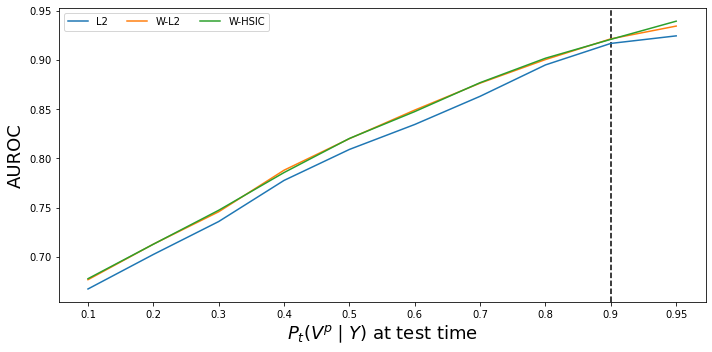

In [9]:
metric = 'micro_auc'
stat = 'mean'
fig = plt.figure(figsize=(10, 5))

# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'
# matplotlib.rcParams['font.weight'] = 'extra bold'
# matplotlib.rcParams['font.serif'] = 'Computer Modern Roman'
# matplotlib.rcParams['axes.labelsize'] = 32
# matplotlib.rcParams['ytick.labelsize'] = 24
# matplotlib.rcParams['xtick.labelsize'] = 24
# matplotlib.rcParams["legend.columnspacing"] = 1

# legend_text_size = 20

df_lst = [uw_eval, w_eval, wh_eval] 
lab_lst = ['L2', 'W-L2', 'W-HSIC']

col_lst = ['black','#336633', '#CC3300'] 
generate_plot(df_lst, lab_lst, metric, stat)
_ = plt.legend(loc = 'upper left', ncol=3)
_ = plt.ylabel("AUROC", size=18)

# for df_i, df in enumerate(df_lst):
#     if f'{metric}_{stat}' in df.columns:
#         plt.bar([i + width * df_i for i in x_loc], df[f'{metric}_{stat}'], 
#                      width=bar_width, yerr= df[f'{metric}_std'], label=lab_lst[df_i], 
#                      capsize= 5, color = col_lst[df_i])
#     else: 
#         plt.bar([i + width * df_i for i in x_loc], df[metric], 
#                      width=bar_width, label=lab_lst[df_i], 
#                      capsize= 5)
    
# plt.ylim(bottom=0.5)
plt.tight_layout()
savename = f'{base_dir}/final_models/dr_main.pdf'
plt.savefig(savename)
cropped_savename = f'{base_dir}/final_models/dr_main_cropped.pdf' 
crop(["-p", "5", savename, "-o", cropped_savename])




In [12]:
random_seed = 9
model_name = 'weighted_hsic'
xv_mode = 'two_step'
curr_pred = pd.read_csv(
    (f'{base_dir}/final_models/opt_pred_rs{random_seed}_{model_name}_{xv_mode}'
     f'_pix{pixel}_bs{batch_size}_py1y0{py1y0}.csv')) 
# print("mean")
# print(curr_pred.mean())

# print("var")
# print(curr_pred.var())

print("max")
print(curr_pred.max())


max
y0                                 4.0
y1                                 1.0
predictions0                  0.999962
predictions1                  0.107918
predictions2                  0.269828
predictions3                  0.155611
predictions4                   0.09253
pred_class                           0
dist                              0.95
model           weighted_hsic_two_step
dtype: object


In [116]:
metric = 'macro_auc'
stat = 'mean'
fig = plt.figure(figsize=(12, 7))


df_lst = [uw_eval, w_eval] + wh_eval_lst
lab_lst = ['DNN', 'wDNN'] + [
    f'o{i}' for i in range(len(wh_eval_lst))]
# col_lst = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(len(df_lst))]
col_lst = ['black','#FF9900', '#336633', '#3333CC',  '#9900CC', '#C85200'] 
generate_plot(df_lst, lab_lst, metric, stat)


# for df_i, df in enumerate(df_lst):
#     if f'{metric}_{stat}' in df.columns:
#         plt.bar([i + width * df_i for i in x_loc], df[f'{metric}_{stat}'], 
#                      width=bar_width, yerr= df[f'{metric}_std'], label=lab_lst[df_i], 
#                      capsize= 5, color = col_lst[df_i])
#     else: 
#         plt.bar([i + width * df_i for i in x_loc], df[metric], 
#                      width=bar_width, label=lab_lst[df_i], 
#                      capsize= 5)
    
# plt.ylim(bottom=0.1)
plt.legend(loc = 'upper left')


NameError: name 'wh_eval_lst' is not defined

<Figure size 864x504 with 0 Axes>

In [84]:
metric = 'log_loss'
stat = 'mean'
fig = plt.figure(figsize=(12, 7))


df_lst = [uw_eval, w_eval] + wh_eval_lst
lab_lst = ['DNN', 'wDNN'] + [
    f'o{i}' for i in range(len(wh_eval_lst))]
# col_lst = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(len(df_lst))]
col_lst = ['black','#FF9900', '#336633', '#3333CC',  '#9900CC', '#C85200'] 
generate_plot(df_lst, lab_lst, metric, stat)


# for df_i, df in enumerate(df_lst):
#     if f'{metric}_{stat}' in df.columns:
#         plt.bar([i + width * df_i for i in x_loc], df[f'{metric}_{stat}'], 
#                      width=bar_width, yerr= df[f'{metric}_std'], label=lab_lst[df_i], 
#                      capsize= 5, color = col_lst[df_i])
#     else: 
#         plt.bar([i + width * df_i for i in x_loc], df[metric], 
#                      width=bar_width, label=lab_lst[df_i], 
#                      capsize= 5)
    
# plt.ylim(bottom=0.1)
plt.legend(loc = 'upper left')

NameError: name 'wh_eval_lst' is not defined

<Figure size 864x504 with 0 Axes>

In [85]:
metric = 'worst_auc'
stat = 'mean'
fig = plt.figure(figsize=(12, 7))

df_lst = [uw_eval, w_eval] + wh_eval_lst
lab_lst = ['DNN', 'wDNN'] + [
    f'o{i}' for i in range(len(wh_eval_lst))]
# col_lst = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(len(df_lst))]
col_lst = ['black','#FF9900', '#336633', '#3333CC',  '#9900CC', '#C85200'] 
generate_plot(df_lst, lab_lst, metric, stat)


# for df_i, df in enumerate(df_lst):
#     if f'{metric}_{stat}' in df.columns:
#         plt.bar([i + width * df_i for i in x_loc], df[f'{metric}_{stat}'], 
#                      width=bar_width, yerr= df[f'{metric}_std'], label=lab_lst[df_i], 
#                      capsize= 5, color = col_lst[df_i])
#     else: 
#         plt.bar([i + width * df_i for i in x_loc], df[metric], 
#                      width=bar_width, label=lab_lst[df_i], 
#                      capsize= 5)
    
plt.ylim(bottom=0.1)
plt.legend(loc = 'upper left')

NameError: name 'wh_eval_lst' is not defined

<Figure size 864x504 with 0 Axes>

In [10]:
def sigmoid(x):
	return 1 / (1 + np.exp(-x))

In [11]:
sigmoid(0.84)

0.6984652160025387

In [12]:
sigmoid(0.4)

0.598687660112452